## **Submission Kelas "Belajar Pengembangan Machine Learning"**

### **Proyek Akhir : Image Classification Model Deployment**

Nama : Patricia Vhiola Palada

No. Registrasi : 0182180260-6

Email: patriciapalada88@gmail.com


 ***Summary:***
Submission ini menggunakan dataset yang berasal dari https://www.kaggle.com/crowww/a-large-scale-fish-dataset. Terdapat 9 class yang berisi jenis-jenis ikan. 

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import zipfile


import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import load_model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from keras.preprocessing import image
from keras.callbacks import EarlyStopping, History

from google.colab import files

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/MyDrive/SUBMISSION'
%cd /content/gdrive/MyDrive/SUBMISSION

/content/gdrive/MyDrive/SUBMISSION


In [4]:
!kaggle datasets download -d crowww/a-large-scale-fish-dataset

a-large-scale-fish-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
local_zip = '/content/gdrive/MyDrive/SUBMISSION/a-large-scale-fish-dataset.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [6]:
dataset_path = Path(r'/tmp/Fish_Dataset/Fish_Dataset')

file_path = list(dataset_path.glob(r'**/*.png'))

labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], file_path))

In [7]:
file_path = pd.Series(file_path).astype(str)
labels = pd.Series(labels)

df = pd.concat([file_path, labels], axis=1)

df.columns = ['image', 'label']
df.head()

,image,label
0,/tmp/Fish_Dataset/Fish_Dataset/Gilt-Head Bream...,Gilt-Head Bream
1,/tmp/Fish_Dataset/Fish_Dataset/Gilt-Head Bream...,Gilt-Head Bream
2,/tmp/Fish_Dataset/Fish_Dataset/Gilt-Head Bream...,Gilt-Head Bream
3,/tmp/Fish_Dataset/Fish_Dataset/Gilt-Head Bream...,Gilt-Head Bream
4,/tmp/Fish_Dataset/Fish_Dataset/Gilt-Head Bream...,Gilt-Head Bream


In [8]:
df.shape

(18000, 2)

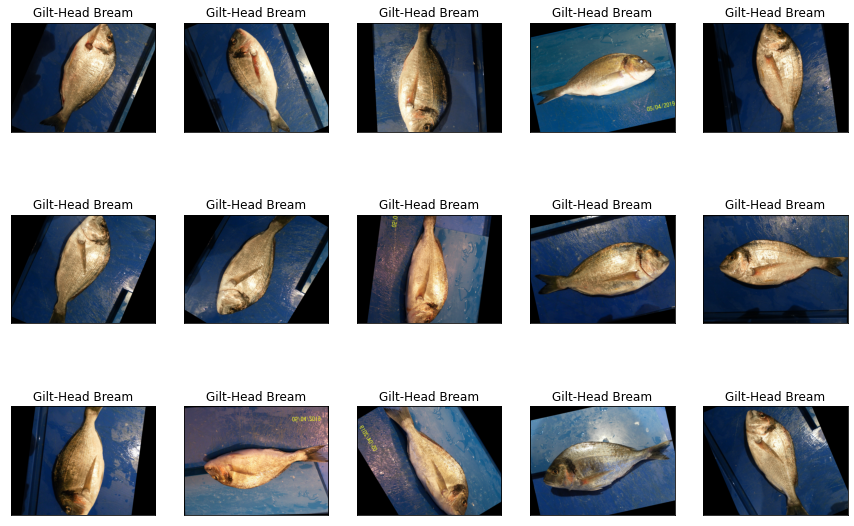

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15,10), subplot_kw={'xticks':[], 'yticks':[]})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df.image[i]))
    ax.set_title(df.label[i])
    
plt.show()

In [10]:
df.label.value_counts()

Striped Red Mullet       1000
Black Sea Sprat          1000
Red Mullet GT            1000
Hourse Mackerel          1000
Gilt-Head Bream GT       1000
Striped Red Mullet GT    1000
Red Mullet               1000
Red Sea Bream            1000
Red Sea Bream GT         1000
Shrimp                   1000
Sea Bass                 1000
Black Sea Sprat GT       1000
Gilt-Head Bream          1000
Trout GT                 1000
Sea Bass GT              1000
Hourse Mackerel GT       1000
Trout                    1000
Shrimp GT                1000
Name: label, dtype: int64

In [11]:
df = df[df['label'].apply(lambda x: x[-2:] != 'GT')].reset_index(drop=True)
df.label.value_counts()

Striped Red Mullet    1000
Black Sea Sprat       1000
Red Sea Bream         1000
Red Mullet            1000
Trout                 1000
Gilt-Head Bream       1000
Hourse Mackerel       1000
Sea Bass              1000
Shrimp                1000
Name: label, dtype: int64

In [12]:
x_train, x_test = train_test_split(df, test_size=0.2,random_state=30)
x_train, x_val = train_test_split(x_train, test_size=0.2, random_state=30)

In [13]:
print("Shape of training data", x_train.shape)
print("Shape of test data", x_test.shape)
print("Shape of validation data", x_val.shape)

Shape of training data (5760, 2)
Shape of test data (1800, 2)
Shape of validation data (1440, 2)


In [14]:
image_data_generator = ImageDataGenerator(rescale = 1./255,
    rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

train = image_data_generator.flow_from_dataframe(dataframe=x_train,
                                                 x_col='image', 
                                                 y_col='label', 
                                                 target_size=(200,200),
                                                 color_mode='rgb', 
                                                 class_mode='categorical',
                                                 shuffle=False)
test = image_data_generator.flow_from_dataframe(dataframe=x_test,
                                                x_col='image',
                                                y_col='label',
                                                target_size=(200,200), 
                                                color_mode='rgb', 
                                                class_mode='categorical', 
                                                shuffle=False)

val = image_data_generator.flow_from_dataframe(dataframe=x_val, 
                                               x_col='image', 
                                               y_col='label', 
                                               target_size=(200,200), 
                                               color_mode='rgb', 
                                               class_mode='categorical',
                                               shuffle=False)

Found 5760 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 1440 validated image filenames belonging to 9 classes.


In [15]:
class Callback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > 0.92 and logs.get('val_accuracy') > 0.92):
            print("\nReached 92% accuracy") 
            self.model.stop_training = True 
 
callbacks = Callback()

In [16]:
input_shape = (200, 200, 3)
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=input_shape ),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size = (2,2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(9, activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 32)        18464     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 32)        9

In [17]:
model.compile(optimizer="adam",
              loss='categorical_crossentropy', 
              metrics=["accuracy"])

In [18]:
%%time
history = model.fit(train, 
                    validation_data=val,
                    epochs=50,
                    callbacks=[callbacks])

Epoch 1/50
180/180 [==============================] - 690s 4s/step - loss: 2.0196 - accuracy: 0.1842 - val_loss: 1.8249 - val_accuracy: 0.2313
Epoch 2/50
180/180 [==============================] - 677s 4s/step - loss: 1.5971 - accuracy: 0.3349 - val_loss: 1.3106 - val_accuracy: 0.4576
Epoch 3/50
180/180 [==============================] - 675s 4s/step - loss: 1.2127 - accuracy: 0.5007 - val_loss: 1.0780 - val_accuracy: 0.5521
Epoch 4/50
180/180 [==============================] - 670s 4s/step - loss: 1.0120 - accuracy: 0.5835 - val_loss: 0.9576 - val_accuracy: 0.6111
Epoch 5/50
180/180 [==============================] - 671s 4s/step - loss: 0.8898 - accuracy: 0.6472 - val_loss: 0.8133 - val_accuracy: 0.6625
Epoch 6/50
180/180 [==============================] - 659s 4s/step - loss: 0.7890 - accuracy: 0.6877 - val_loss: 0.8282 - val_accuracy: 0.6528
Epoch 7/50
180/180 [==============================] - 665s 4s/step - loss: 0.7641 - accuracy: 0.6955 - val_loss: 0.6204 - val_accuracy: 0.7403

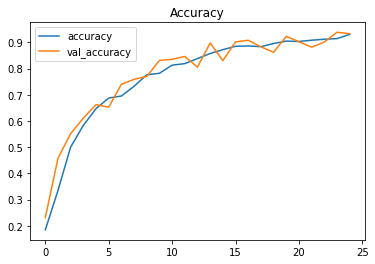

In [19]:
pd.DataFrame(history.history)[['accuracy','val_accuracy']].plot()
plt.title("Accuracy")
plt.show()

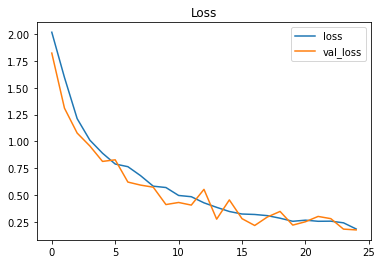

In [20]:
pd.DataFrame(history.history)[['loss','val_loss']].plot()
plt.title("Loss")
plt.show()

In [22]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpq0xtfevt/assets
